In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from haversine import haversine
from gurobipy import *

%matplotlib inline

Load data and separate into weighted and non-weighted parts.

In [2]:
adjMatrix = pd.read_csv('HW2_problem 2.txt', sep=" ", header = None)

# remove first column
adjMatrix = adjMatrix.drop(adjMatrix.columns[[0]], axis=1)

# divide matrix into matrix with connections, and matrix with weights
adjMatrixConn = adjMatrix[0:34]
adjMatrixWeights = adjMatrix[34:]

# re-index to 1
adjMatrixConn.index += 1 
# adjMatrixWeights.index += 1 
adjMatrixWeights.index = range(1,35)

Create undirected graph from adjaceny matrix and relabel nodes from 1 to 34.

In [3]:
G = nx.Graph(adjMatrixConn.values)

# relabel nodes
mapping = dict(zip(G.nodes(),range(1,35)))
G = nx.relabel_nodes(G,mapping)

Draw graph G to get a better understanding of the structure of the network.

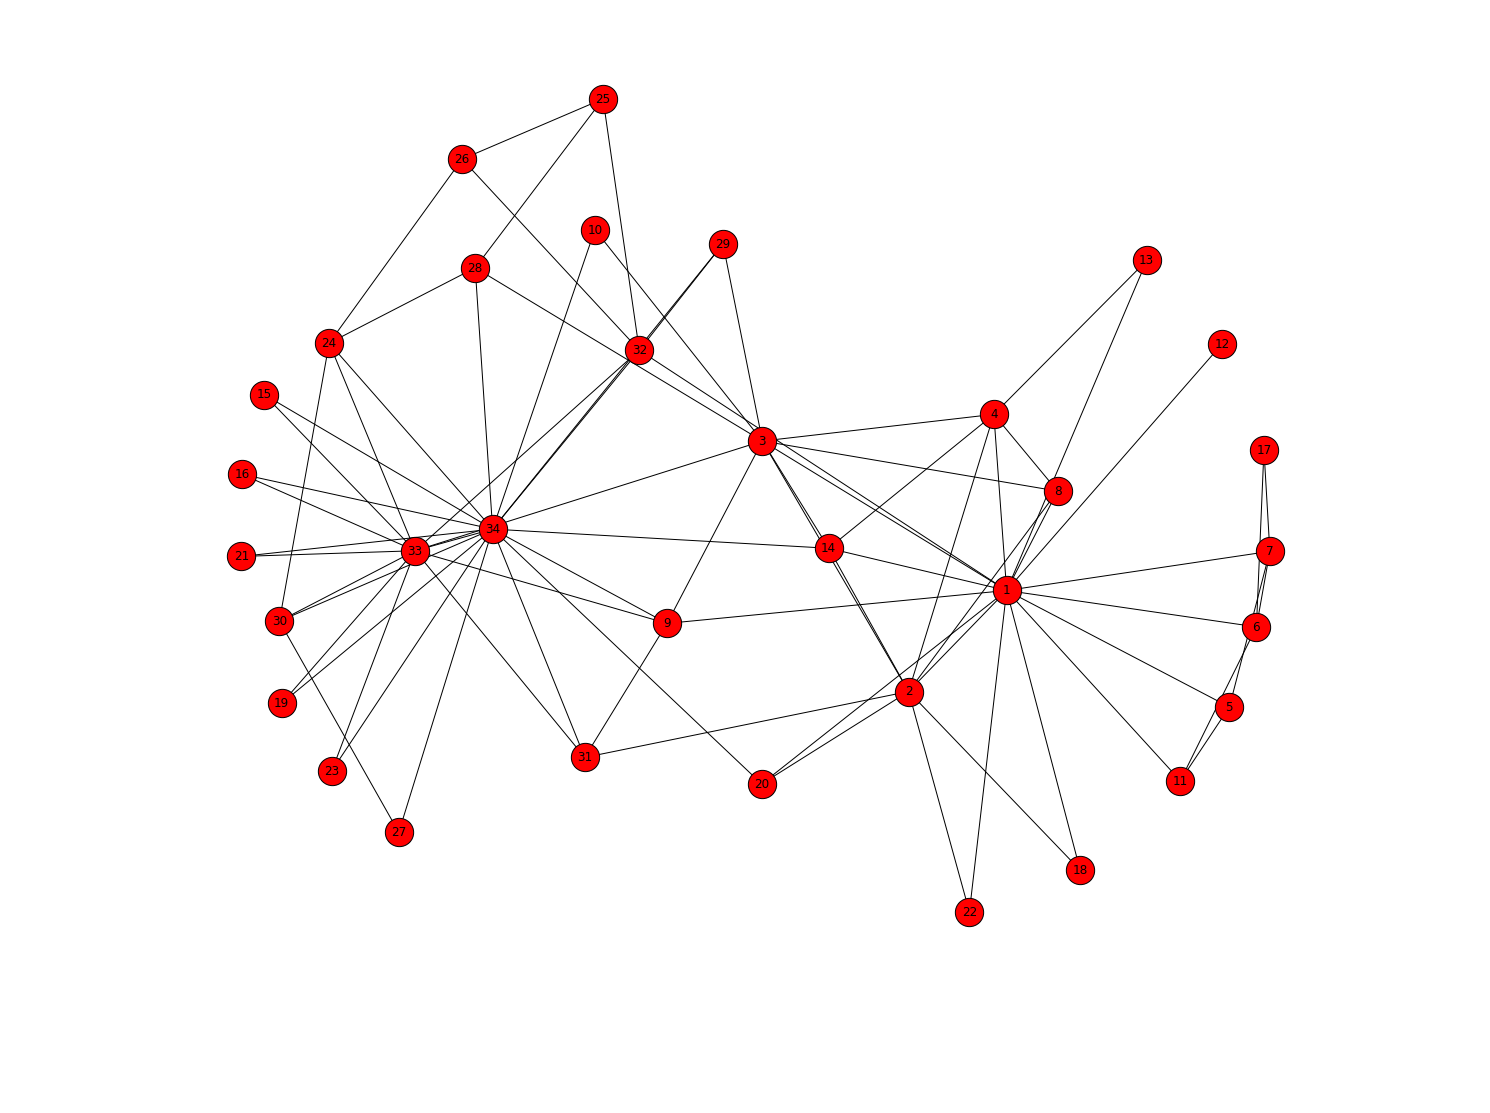

In [4]:
plt.figure(figsize=(20,15))

nx.draw(G, with_labels=True, node_size=800)

# Exercise 2

### Betweenness centrality:

$$ g(v) = \sum_{j \neq k \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}$$

In [7]:
betwC = nx.betweenness_centrality(G, normalized=False)

betwC_dframe = pd.DataFrame.from_dict(betwC, orient='index')
betwC_dframe.columns = ['Betweenness Centrality']

betwC_dframe.sort_values(['Betweenness Centrality'], ascending = False).head(2)

,Betweenness Centrality
1,231.071429
34,160.551587


The betweenness centrality of a node measures if a node is on the shortest path between all possible pairs of other nodes. If a node has a high degree of betweenness centrality it is a pivotal node to connecting other pairs of nodes. Nodes 1 and 34 are the three most important nodes in the organization network. The graph above illustrates quite clearly how the two nodes play a central role. A lot of the peripheral clusters to the central nodes are not connected between each other making the central nodes important for the peripheral clusters to be able to communicate between each other.

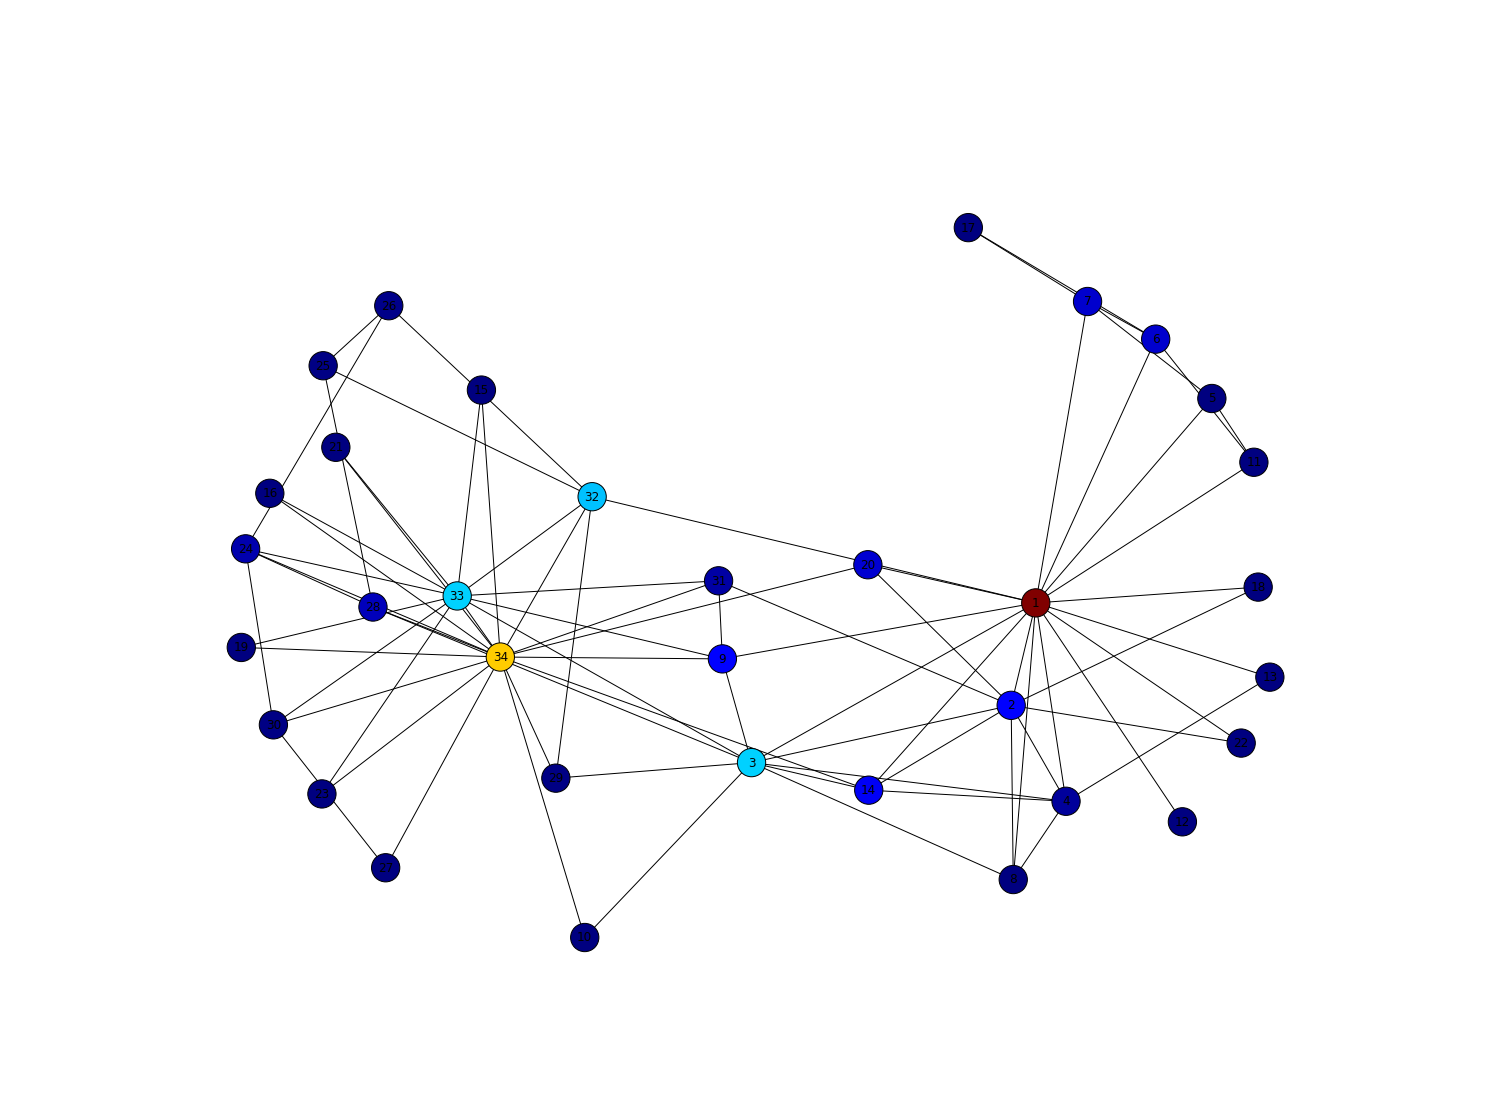

In [6]:
plt.figure(figsize=(20,15))

# assign values to nodes
values = [betwC.get(node, 0.25) for node in G.nodes()]

nx.draw(G, node_size=800, node_color=values, with_labels=True)

# ranking of nodes
# blue = low rank
# red = high rank

### Closeness centrality:

$$ C(x) = \frac{1}{\sum_{y} d(y,x)} $$

In [7]:
closC = nx.closeness_centrality(G)

closC_dframe = pd.DataFrame.from_dict(closC, orient='index')
closC_dframe.columns = ['Closeness Centrality']

closC_dframe.sort_values(['Closeness Centrality'], ascending = False).head(2)

,Closeness Centrality
1,0.568966
3,0.559322


The closeness centrality of node "g" measures the average shortest path from "g" to all other nodes in a connected graph. The more central node "g" is, the closer it is to all other nodes. In our organization network, nodes 1 and 3 are the most important. Both have a short average distance to all other nodes making them important in the organization network. This measure of centrality is useful to identify people in an organization that might be able to influence the greatest number of people in the shortest amount of time.

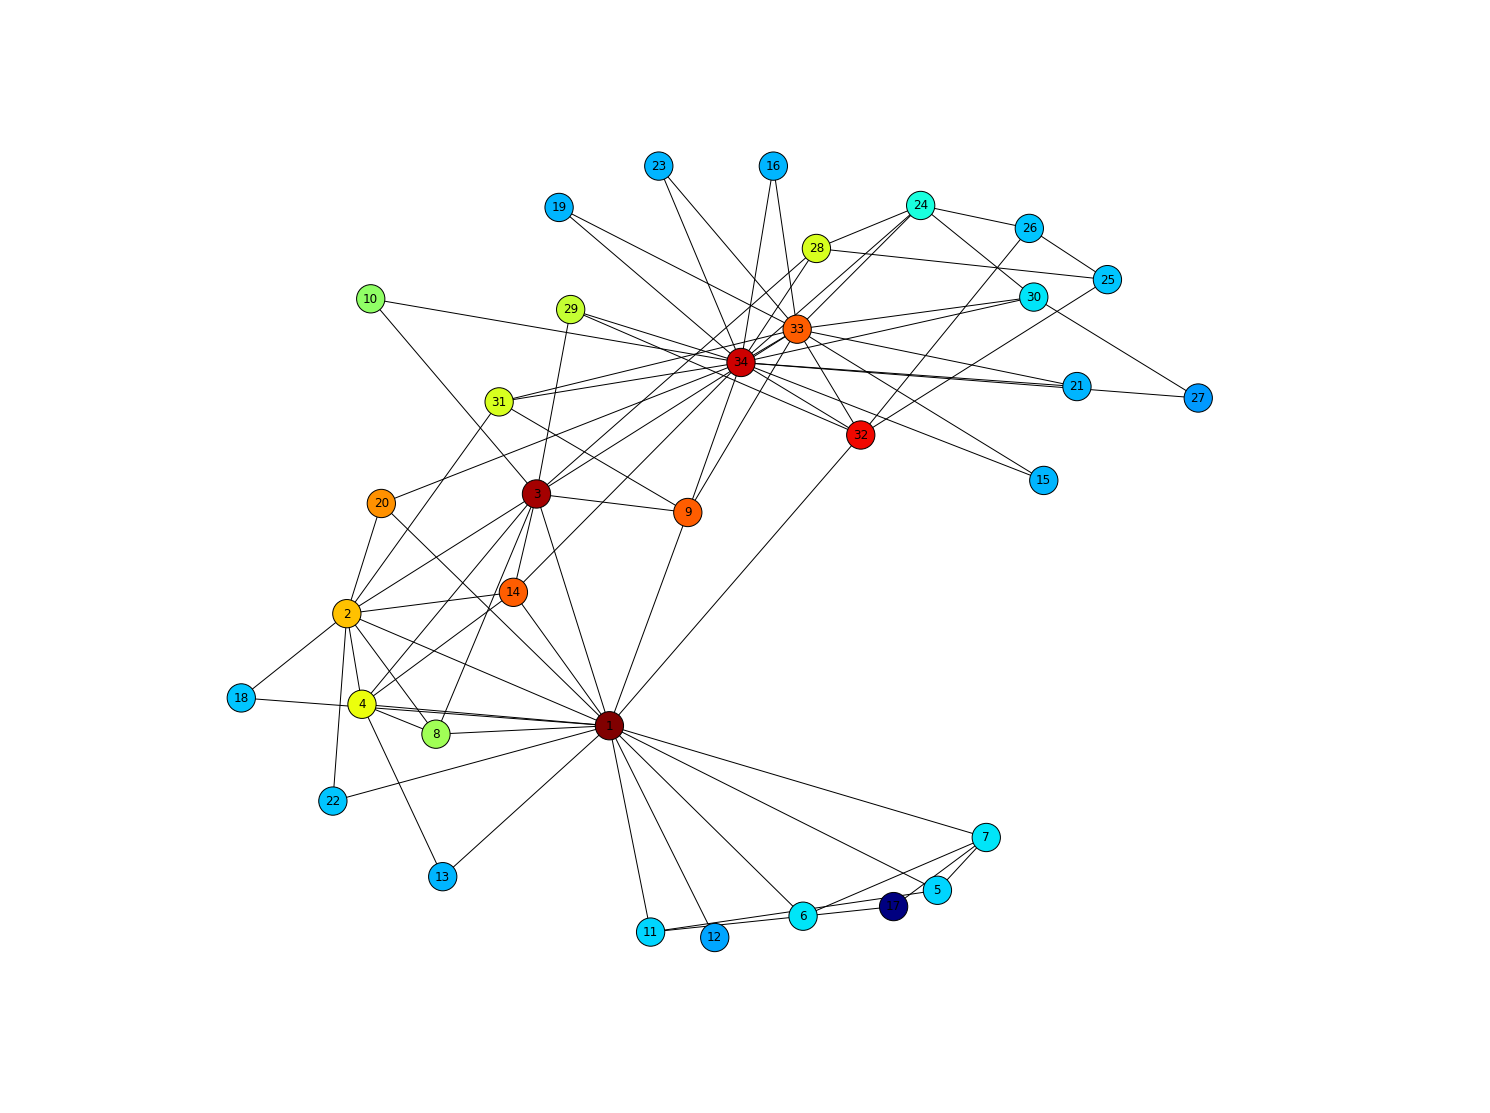

In [8]:
plt.figure(figsize=(20,15))

# assign values to nodes
values = [closC.get(node, 0.25) for node in G.nodes()]

nx.draw(G, node_size=800, node_color=values, with_labels=True)

### Edge betweenness centrality:

$$ c_{B}(v) = \sum_{s,t \in V} \frac{\sigma(s,t | e)}{\sigma(s,t)} $$

In [9]:
edgebC = nx.edge_betweenness_centrality(G)

edgebC_dframe = pd.DataFrame.from_dict(edgebC, orient='index')
edgebC_dframe.columns = ['Edge Betweenness Centrality']

edgebC_dframe.sort_values(['Edge Betweenness Centrality'], ascending = False).head(2)

,Edge Betweenness Centrality
"(1, 32)",0.127260
"(1, 7)",0.078134


Exlanation!

### Eigenvector centrality:

$$ x_{v} = \frac{1}{\lambda} \sum_{t \in M(v)} x_{t} = \frac{1}{\lambda} \sum_{t \in G} a_{v,t}x_{t} $$

In [10]:
eigenvC = nx.eigenvector_centrality(G)

eigenvC_dframe = pd.DataFrame.from_dict(eigenvC, orient='index')
eigenvC_dframe.columns = ['Eigenvector Centrality']

eigenvC_dframe.sort_values(['Eigenvector Centrality'], ascending = False).head(2)

,Eigenvector Centrality
34,0.373363
1,0.355491


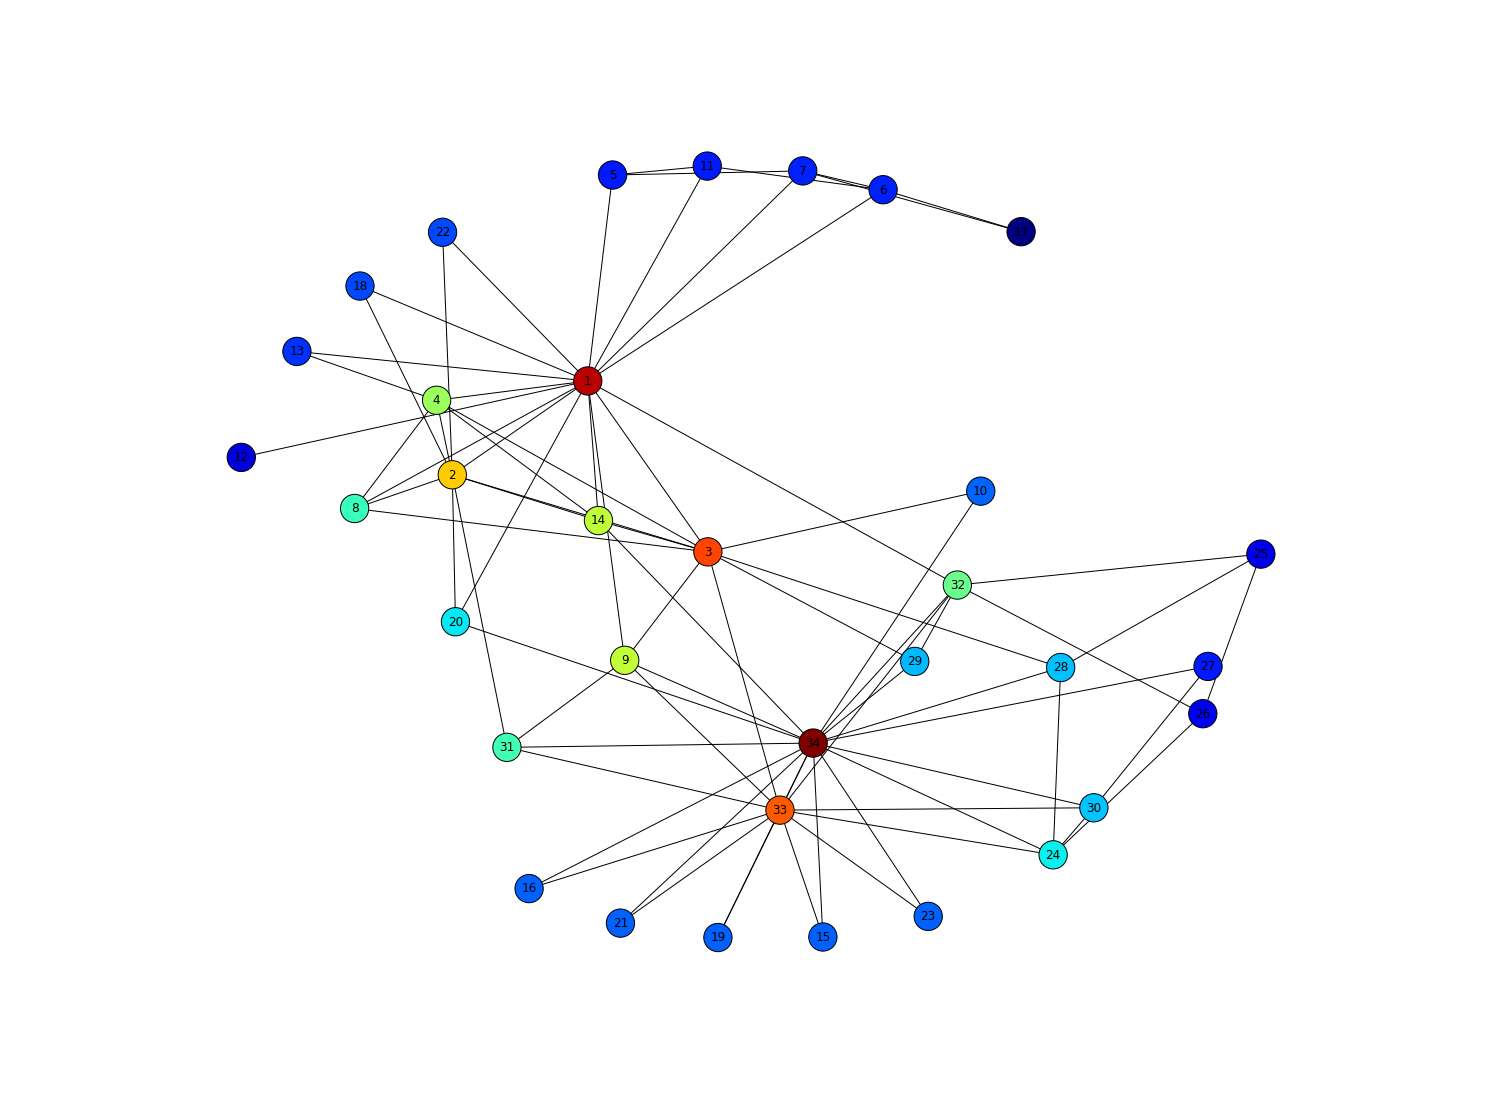

In [11]:
plt.figure(figsize=(20,15))

# assign values to nodes
values = [eigenvC.get(node, 0.25) for node in G.nodes()]

nx.draw(G, node_size=800, node_color=values, with_labels=True)

The eigenvector centrality measures the influence of a particular node in a graph G. This influence is based on the connectedness of a node to other influencial nodes. The higher the influence of a node, the higher its eigenvector centrality. The most important nodes using this measure of centrality are nodes 34 and 1. This measure of centrality could be useful if we would like to determine who has the most influential direct surrounding within a company.

# Exercise 3

### a. Plot the latitude and longitude data as a scatter plot

In [12]:
# load data
data = pd.read_csv('HW2_tsp.txt', sep=" ", header = None)

# assign proper names to columns
data.columns = ['city', 'latitude', 'longitude']

# scale coordinates
data['latitude'] = data['latitude'] / 1000
data['longitude'] = data['longitude'] / 1000

# display data
data.head()

,city,latitude,longitude
0,1,11.003611,42.102500
1,2,11.108611,42.373889
2,3,11.133333,42.885833
3,4,11.155833,42.712500
4,5,11.183333,42.933333


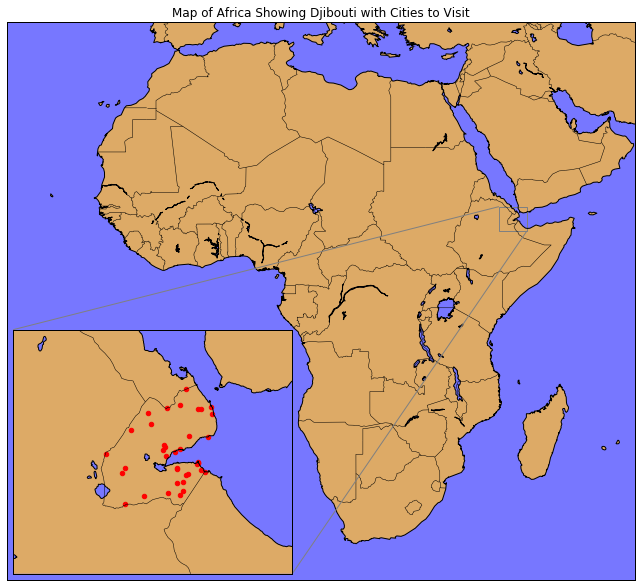

In [13]:
fig = plt.figure()
fig = plt.figure(figsize=(20,10))
plt.title('Map of Africa Showing Djibouti with Cities to Visit')

# Create subplot
ax = fig.add_subplot(111)

map = Basemap(llcrnrlon=-30,llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40, resolution = 'l')

# Draw country borders on the map
map.drawcountries()

map.drawmapboundary(fill_color='#7777ff')
map.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
map.drawcoastlines()

x,y = map(data['longitude'].values, data['latitude'].values)

# adjust size and location of subplot
axins = zoomed_inset_axes(ax, 10, loc=3)
axins.set_xlim(-20, 0)
axins.set_ylim(3, 18)

plt.xticks(visible=False)
plt.yticks(visible=False)

map2 = Basemap(llcrnrlon=40.5,llcrnrlat=10,urcrnrlon=44.5,urcrnrlat=13.5, ax=axins, resolution = 'h')
map2.drawmapboundary(fill_color='#7777ff')
map2.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
map2.drawcoastlines()
map2.drawcountries()

map2.scatter(x, y, color= 'r')

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show();

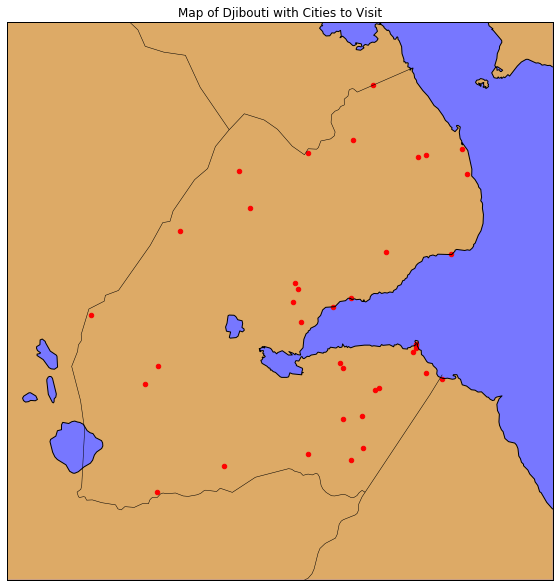

In [14]:
fig = plt.figure(figsize=(20,10))
plt.title('Map of Djibouti with Cities to Visit')

plt.xticks(visible=False)
plt.yticks(visible=False)

map3 = Basemap(llcrnrlon=41.5,llcrnrlat=10.65,urcrnrlon=43.7,urcrnrlat=12.9, resolution = 'h')

map3.drawcountries()

map3.drawmapboundary(fill_color='#7777ff')
map3.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
map3.drawcoastlines()

map3.scatter(x, y, color= 'r')

plt.show()

### b. Use the or-tools traveling salesman routine to find a tour of the 38 cities.

First create a distance matrix using the code in HW2 part 1.

In [15]:
def distMatrix(listOfCities):
    
    # input: list of cities
    # output: distance matrix, distance between all pairs of cities
    
    # create empty distance matrix
    
    matrix = np.zeros([len(listOfCities), len(listOfCities)])
    
    for i in range(len(listOfCities)):
        for j in range(len(listOfCities)):
            city1 = (data.ix[i,1], data.ix[i,2])
            city2 = (data.ix[j,1], data.ix[j,2])
            matrix [i, j] = haversine(city1, city2)
            
    return matrix

dMatrix = distMatrix(data)
dMatrix = pd.DataFrame(dMatrix).round(2)

dMatrix.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.00,31.84,86.69,68.68,92.83,88.19,96.44,106.49,108.50,48.59,...,117.72,133.80,197.45,148.59,189.15,191.99,166.05,204.09,179.77,205.65
1,31.84,0.00,55.92,37.31,61.60,56.36,64.61,74.77,76.78,50.37,...,107.38,116.28,169.09,132.63,162.76,165.36,145.29,176.46,156.66,182.87
2,86.69,55.92,0.00,19.08,7.60,18.60,20.24,33.25,34.63,96.51,...,127.41,121.42,138.09,138.77,139.09,140.70,139.12,147.68,143.26,168.36
3,68.68,37.31,19.08,0.00,24.28,22.00,29.24,41.39,43.28,78.05,...,115.07,113.41,143.95,130.81,141.91,143.95,135.32,152.71,142.16,168.00
4,92.83,61.60,7.60,24.28,0.00,15.40,14.12,26.51,27.73,99.65,...,126.19,118.34,131.04,135.57,132.62,134.13,134.45,140.76,137.76,162.59


In [16]:
# create model
m = Model()

# create decision variables

vars = {}

for i in range(len(dMatrix)):
    for j in range(i+1):
        
        vars[i,j] = m.addVar(obj=dMatrix.ix[i, j], vtype=GRB.BINARY, name='e'+str(i)+'_'+str(j))
        vars[j,i] = vars[i,j]
        
    m.update()

In [17]:
# Callback - use lazy constraints to eliminate sub-tours

def subtourelim(model, where):
    if where == GRB.callback.MIPSOL:
        selected = []
        # make a list of edges selected in the solution
        for i in range(len(dMatrix)):
            sol = model.cbGetSolution([model._vars[i,j] for j in range(len(dMatrix))])
            selected += [(i,j) for j in range(len(dMatrix)) if sol[j] > 0.5]
        # find the shortest cycle in the selected edge list
        tour = subtour(selected)
        if len(tour) < len(dMatrix):
            # add a subtour elimination constraint
            expr = 0
            for i in range(len(tour)):
                for j in range(i+1, len(tour)):
                    expr += model._vars[tour[i], tour[j]]
            model.cbLazy(expr <= len(tour)-1)


# Given a list of edges, finds the shortest subtour

def subtour(edges):
    visited = [False]*len(dMatrix)
    cycles = []
    lengths = []
    selected = [[] for i in range(len(dMatrix))]
    for x,y in edges:
        selected[x].append(y)
    while True:
        current = visited.index(False)
        thiscycle = [current]
        while True:
            visited[current] = True
            neighbors = [x for x in selected[current] if not visited[x]]
            if len(neighbors) == 0:
                break
            current = neighbors[0]
            thiscycle.append(current)
        cycles.append(thiscycle)
        lengths.append(len(thiscycle))
        if sum(lengths) == len(dMatrix):
            break
    return cycles[lengths.index(min(lengths))]

# Add degree-2 constraint, and forbid loops

for i in range(len(dMatrix)):
    m.addConstr(quicksum(vars[i,j] for j in range(len(dMatrix))) == 2)
    vars[i,i].ub = 0

m.update()

# Optimize model

m._vars = vars
m.params.LazyConstraints = 1
m.optimize(subtourelim)

solution = m.getAttr('x', vars)
selected = [(i,j) for i in range(len(dMatrix)) for j in range(len(dMatrix)) if solution[i,j] > 0.5]
assert len(subtour(selected)) == len(dMatrix)

Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 38 rows, 741 columns and 1444 nonzeros
Variable types: 0 continuous, 741 integer (741 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 3384.53
Presolve removed 0 rows and 38 columns
Presolve time: 0.00s
Presolved: 38 rows, 703 columns, 1406 nonzeros
Variable types: 0 continuous, 703 integer (703 binary)

Root relaxation: objective 6.993500e+02, 49 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  699.35000    0   10 3384.53000  699.35000  79.3%     -    0s
H    0     0                     854.9700000  699.35000  18.2%     -    0s
H    0     0                     851.7100000  699.35000  17

Plot resulting tour

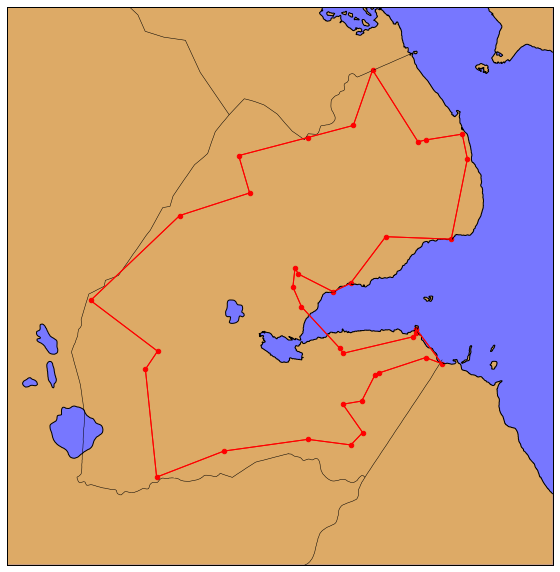

In [18]:
fig = plt.figure(figsize=(20,10))
plt.title('TSP Djibouti')

plt.xticks(visible=False)
plt.yticks(visible=False)

map3 = Basemap(llcrnrlon=41.5,llcrnrlat=10.65,urcrnrlon=43.7,urcrnrlat=12.9, resolution = 'f')

map3.drawcountries()

map3.drawmapboundary(fill_color='#7777ff')
map3.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
map3.drawcoastlines()

for i in range(len(selected)):
    subData = data.ix[(selected[i][0] ,selected[i][1]),]
    x1, y1 = map3(subData['longitude'].values, subData['latitude'].values)
    map3.plot(x1, y1, color= 'r')

map3.scatter(x, y, color= 'r')

plt.show()